# Problem 2
Problem 2 asks to predict the amount of "hits" or purchases in the entirety of the following month for the packages given. These packages are new, meaning that they will be introduced in that month. So, the main challenge is to figure out to predict the test data using the historical data of other continuing and discontinued packages.

# Package imports and preamble

## Install Required Packages

In [182]:
!pip install pandas scikit-learn xgboost seaborn

## Import data from Amazon S3 buckets and write them to a file

In [108]:
import boto3
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [184]:
# Initialize a boto3 client with your AWS credentials
# Access key ID & Secret access key shared in your mail
s3_client = boto3.client(
    's3',
    aws_access_key_id='',
    aws_secret_access_key=''
)

### Read  CSV file from S3
# Specify your  AWS S3 bucket  name
bucket_name = 'datathon-3.0'
read_file_name = 'Q2-new-products.csv'

# Get the object from the bucket
response = s3_client.get_object(Bucket=bucket_name, Key=read_file_name)

# Read the object (which is in bytes) into a DataFrame
with open(read_file_name, 'wb') as fp:
    fp.write(BytesIO(response['Body'].read()).getbuffer())

df = pd.read_csv(read_file_name)
df.head()

,PACK_ID
0,352
1,1735
2,179
3,1434
4,426


## Product table
This table contains detailed information about all the packages that were once available, are currently available and will be introduced in the future. We will engineer an additional feature to better understand the value proposition of a package, named "Unit price" which will be the price per GB.

In [109]:
product_df = pd.read_csv('TBL_PRODUCT_CATALOGUE.csv')
product_df['UNIT_PRICE'] = product_df['PACK_PRICE'] / product_df['DATA_VOL_GB']
product_df.head()

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,UNIT_PRICE
0,1,Standard,Digital Wallets,1298,30,320.0,Discontinue,4.056250
1,2,Standard,Cash,328,30,24.0,Continue,13.666667
2,3,Premium,Mobile Walet,176,3,24.0,Discontinue,7.333333
3,4,Premium,Cash,558,15,64.0,Discontinue,8.718750
4,5,Premium,Cash,300,7,20.0,New,15.000000


## Purchase table
This table contains the package transaction history of each customer

In [110]:
purchase_df = pd.read_csv('TBL_PACK_PURCHASE.csv')
purchase_df.head()

,EVENT_DATE,CUSTOMER_ID,PACK_ID,HITS
0,20190703,CD20EDFC8000A7,1756,1
1,20190522,CD1F932E0A89C1,1524,1
2,20190522,CD201715F62164,1524,1
3,20190623,CD1F7B4DD83C5B,1524,1
4,20190523,CD1F7BD12742B8,1524,1


## Consumption table
This table contains the historical data usage patterns of each user

In [111]:
consumption_df = pd.read_csv('TBL_DATA_CONSUMPTION.csv')
print(len(consumption_df))
consumption_df.head()

23375373


,EVENT_DATE,CUSTOMER_ID,TOTAL_VOLUME_GB,VOLUME_GB_IN_HIGH_BANDWIDTH
0,20190914,CD1F7653F6BE80,14.2695,14.2695
1,20190916,CD1F7653F6BE80,22.2891,22.2891
2,20190716,CD1F7653F6BE80,26.3086,26.3086
3,20190906,CD1F7653F6BE80,6.8477,6.7813
4,20190921,CD1F7653F6BE80,15.1406,15.1406


## New products table
These are the IDs of the packages that we need to predict the monthly purchase amounts for.

In [112]:
test_df = pd.read_csv('Q2-new-products.csv')
test_df.head()

,PACK_ID
0,352
1,1735
2,179
3,1434
4,426


# Understanding the data

Let's associate the purchase history with the package details to get a better insight.

In [138]:
purchase_product_df = pd.merge(purchase_df, product_df, how='inner', on='PACK_ID')
purchase_product_df['EVENT_DATE'] = pd.to_datetime(purchase_product_df['EVENT_DATE'], format='%Y%m%d')
purchase_product_df.sort_values(by='EVENT_DATE', inplace=True, ignore_index=True)
purchase_product_df['TOTAL_DATA_VOL_GB'] = purchase_product_df['DATA_VOL_GB'] * purchase_product_df['HITS']
purchase_product_df.head()

,EVENT_DATE,CUSTOMER_ID,PACK_ID,HITS,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,UNIT_PRICE,TOTAL_DATA_VOL_GB
0,2019-05-21,CD218554C71203,278,1,Premium,Cash,356,7,56.0,Discontinue,6.357143,56.0
1,2019-05-21,CD20F0D0031916,1692,1,Premium,Cash,114,3,6.0,Discontinue,19.000000,6.0
2,2019-05-21,CD20F3F3132F06,1692,1,Premium,Cash,114,3,6.0,Discontinue,19.000000,6.0
3,2019-05-21,CD212DD33D5C02,1692,1,Premium,Cash,114,3,6.0,Discontinue,19.000000,6.0
4,2019-05-21,CD212DD6E5B84B,1692,1,Premium,Cash,114,3,6.0,Discontinue,19.000000,6.0


PRODUCT_STATUS
Discontinue    1084280
Continue        124430
Name: count, dtype: int64


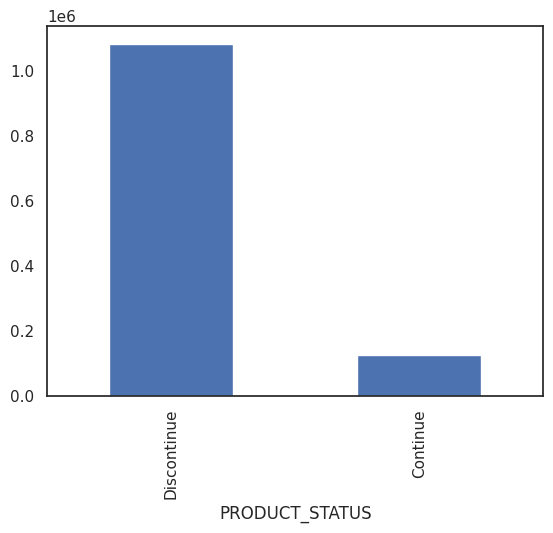

In [142]:
status_counts = purchase_product_df['PRODUCT_STATUS'].value_counts()
print(status_counts)
status_counts.plot(kind='bar')
plt.show()

It seems that the **overwhelming majority of packages have been discontinued**. Let's have a deeper look into the dynamics of these two categories, primarily focusing on discontinued products.

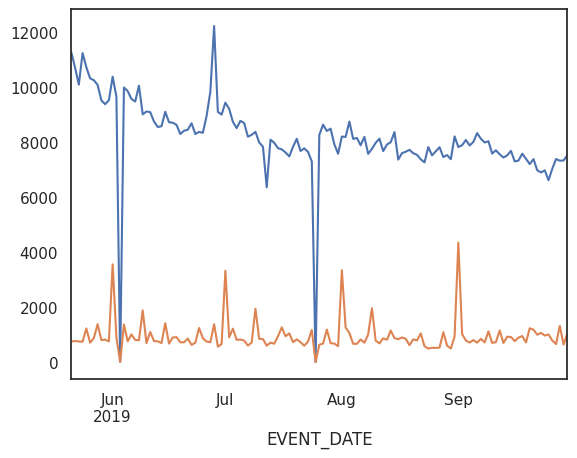

In [115]:
discontinued_products_df = purchase_product_df[purchase_product_df['PRODUCT_STATUS'] == 'Discontinue']
continued_products_df = purchase_product_df[purchase_product_df['PRODUCT_STATUS'] == 'Continue']
daily_hits_discontinued = discontinued_products_df.resample('D', on='EVENT_DATE')['HITS'].sum()
daily_hits_continued = continued_products_df.resample('D', on='EVENT_DATE')['HITS'].sum()
daily_hits_discontinued.plot()
daily_hits_continued.plot()
plt.show()

Quite interestingly, the number of discontinued packages sold face a massive dip from time to time, insinuating that all the products sold that day are current or newly introduced packages that have been in service until now (the cutoff date for the data). The spikes for current packages show a monthly trend, which is quite normal given that salaries are disbursed during this window.

In [143]:
purchase_product_df_filtered = pd.merge(test_df, purchase_product_df, how='inner', on='PACK_ID')
purchase_product_df_filtered.head()

,PACK_ID,EVENT_DATE,CUSTOMER_ID,HITS,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,UNIT_PRICE,TOTAL_DATA_VOL_GB


The dataframe is empty. This confirms that the newly introduced packages do not have any historical data. We will retrieve more details for the packages that need to be predicted.

In [144]:
test_product_df = pd.merge(test_df, product_df, how='inner', on='PACK_ID')
test_product_df.head()

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,UNIT_PRICE
0,352,Premium,Mobile Walet,396,7,52.0,New,7.615385
1,1735,Premium,Digital Wallets,396,7,72.0,New,5.500000
2,179,Premium,Mobile Walet,336,7,32.0,New,10.500000
3,1434,Premium,Mobile Walet,136,7,8.0,New,17.000000
4,426,Premium,Mobile Walet,296,7,20.0,New,14.800000


In [145]:
test_product_df['PAYMENT_METHOD'].value_counts()

PAYMENT_METHOD
Mobile Walet       12
Digital Wallets     7
Credit Card         1
Name: count, dtype: int64

It seems that none of the packages in the test set have a cash-based transaction method.

In [146]:
latest_date_of_purchase = purchase_product_df.iloc[-1]['EVENT_DATE']
latest_date_of_purchase

Timestamp('2019-09-30 00:00:00')

This determines the cut-off date for the given data. Given the problem definition, we need to predict the amount of packages sold for the month of October.

In [147]:
purchase_product_df['CUSTOMER_ID'].nunique()

342635

In [148]:
purchase_product_df['SERVICE_TYPE'].value_counts()

SERVICE_TYPE
Premium     954953
Standard    253757
Name: count, dtype: int64

The number of unique customers and the distribution between the two services do not provide much value from a cursory glance. Premium subscribers are dominating for certain but not to the point where we can disregard the standard customers.

Since the first portion of the data involves the last week of May and not the entirety of, we will get rid of it since it does not capture the monthly trend that we need for our problem. It is also the worst data to pick in terms of recency.

In [149]:
purchase_product_df_filtered = purchase_product_df[purchase_product_df['EVENT_DATE'] >= '2019-06-01']
purchase_product_df_filtered.head()

,EVENT_DATE,CUSTOMER_ID,PACK_ID,HITS,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,UNIT_PRICE,TOTAL_DATA_VOL_GB
122168,2019-06-01,CD1F7EAD621D6C,1330,1,Standard,Digital Wallets,994,30,168.0,Discontinue,5.916667,168.0
122169,2019-06-01,CD20FB9FF49100,812,1,Premium,Cash,296,7,24.0,Discontinue,12.333333,24.0
122170,2019-06-01,CD214ADD83CFA9,622,1,Premium,Credit Card,110,30,4.0,Discontinue,27.500000,4.0
122171,2019-06-01,CD211EBE8FE0DD,1181,1,Premium,Cash,994,30,100.0,Discontinue,9.940000,100.0
122172,2019-06-01,CD20EE296E0002,2047,1,Premium,Cash,120,30,4.0,Continue,30.000000,4.0


Since the majority of packages are discontinued, we need to observe some more patterns to make use of the majority of the data. One thing to consider is the duration between the discontinuation of each package. This can be calculated using the first date of appearance and the last.

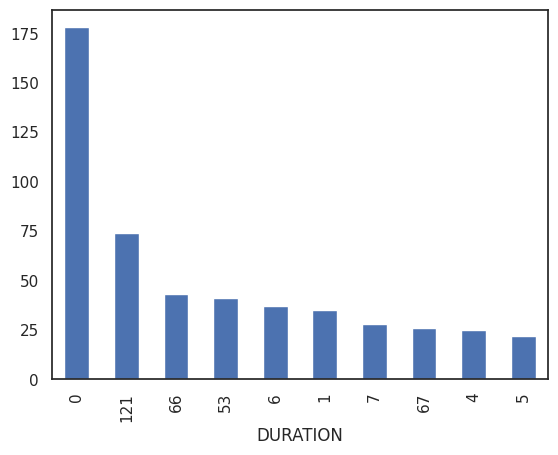

In [150]:
purchase_product_df_discontinued = purchase_product_df_filtered[purchase_product_df_filtered['PRODUCT_STATUS'] == 'Discontinue']
purchase_product_df_last_dates = purchase_product_df_discontinued.drop_duplicates(subset=['PACK_ID'], keep='last')
purchase_product_df_first_dates = purchase_product_df_discontinued.drop_duplicates(subset=['PACK_ID'], keep='first')
purchase_product_df_dates = pd.merge(purchase_product_df_first_dates, purchase_product_df_last_dates, on='PACK_ID', how='inner')
purchase_product_df_dates = purchase_product_df_dates[['PACK_ID', 'EVENT_DATE_x', 'EVENT_DATE_y']].rename(columns={'EVENT_DATE_x': 'START_DATE', 'EVENT_DATE_y': 'LAST_DATE'})
purchase_product_df_dates['DURATION'] = (purchase_product_df_dates['LAST_DATE'] - purchase_product_df_dates['START_DATE']).dt.days
purchase_product_df_dates['DURATION'].value_counts()[:10].plot(kind='bar')
plt.show()

This provides us with a very interesting finding about the distribution of these discontinued packages. Most are discontinued within the same day, meaning that these are special offers. The second highest number goes to roughly two-month-long offerings (day counts 66 and 67). Then there's the highly specific 121-day-long offerings which exhibit a trend of packages being discontinued on a quarterly basis.

For now we will consider the dynamics of the single-day offers versus the other packages. There should be some indication of these packages having special perks.

In [151]:
purchase_product_df_offer = purchase_product_df[purchase_product_df['PACK_ID'].isin(purchase_product_df_dates[purchase_product_df_dates['DURATION'] == 0]['PACK_ID'])]
purchase_product_df_not_offer = purchase_product_df[~purchase_product_df['PACK_ID'].isin(purchase_product_df_dates[purchase_product_df_dates['DURATION'] == 0]['PACK_ID'])]
purchase_product_df_offer.describe().map(lambda x: f"{x:0.3f}")

,EVENT_DATE,PACK_ID,HITS,PACK_PRICE,VALIDITY,DATA_VOL_GB,UNIT_PRICE,TOTAL_DATA_VOL_GB
count,421.000,421.000,421.000,421.000,421.000,421.000,421.000,421.000
mean,0.3f,1035.670,1.043,437.188,19.135,52.431,47.211,56.787
min,0.3f,15.000,1.000,110.000,3.000,0.200,2.281,0.200
25%,0.3f,492.000,1.000,200.000,7.000,12.000,4.938,12.000
50%,0.3f,1095.000,1.000,328.000,30.000,36.000,7.478,36.000
75%,0.3f,1497.000,1.000,672.000,30.000,64.000,22.000,64.000
max,0.3f,2059.000,2.000,3064.000,30.000,440.000,4970.000,880.000
std,nan,607.113,0.203,351.621,12.232,60.544,257.655,79.303


In [152]:
purchase_product_df_not_offer.describe().map(lambda x: f"{x:0.3f}")

,EVENT_DATE,PACK_ID,HITS,PACK_PRICE,VALIDITY,DATA_VOL_GB,UNIT_PRICE,TOTAL_DATA_VOL_GB
count,1208289.000,1208289.000,1208289.000,1208289.000,1208289.000,1208289.000,1208289.000,1208289.000
mean,0.3f,1024.542,1.004,422.142,14.132,54.923,18.066,55.022
min,0.3f,1.000,1.000,100.000,3.000,0.200,0.500,0.200
25%,0.3f,425.000,1.000,178.000,3.000,16.000,6.000,16.000
50%,0.3f,923.000,1.000,296.000,7.000,32.000,8.708,32.000
75%,0.3f,1671.000,1.000,558.000,30.000,80.000,13.600,80.000
max,0.3f,2057.000,13.000,6926.000,30.000,400.000,4980.000,1440.000
std,nan,646.206,0.073,351.503,11.924,56.348,131.793,56.603


Our hypothesis is suppported by the lower unit prices all throughout the special offer packages.

In [156]:
print(f'Unique data volumes : {purchase_product_df["DATA_VOL_GB"].nunique()}')
print(f'Unique data volume pc: {(purchase_product_df["DATA_VOL_GB"].nunique() / len(product_df)) * 100}%')

Unique data volumes : 142
Unique data volume pc: 6.930209858467546%


This is an interesting finding. It essentially enforces that the data volumes are actually discrete categorical values instead of being continuous. The small 6% indicates that the product catalogue is quite larger than the number of unique unique data volumes. So most packages are mixing and matching from this small pool.

# Data Preprocessing

Now to get the monthly sales trends for each package.

In [157]:
monthly_hits = purchase_product_df.groupby(['PACK_ID', purchase_product_df['EVENT_DATE'].dt.to_period('M')])['HITS'].sum().reset_index()
monthly_hits.head()

,PACK_ID,EVENT_DATE,HITS
0,1,2019-08,18
1,1,2019-09,8
2,2,2019-05,12
3,2,2019-06,22
4,2,2019-07,23


In [158]:
date_range = pd.period_range(start='2019-06', end='2019-09', freq='M')
all_combinations = pd.MultiIndex.from_product([product_df['PACK_ID'].unique(), date_range], names=['PACK_ID', 'EVENT_DATE'])

This will fill in the missing months to make all the packages align within the same time window.

In [159]:
monthly_hits = monthly_hits.set_index(['PACK_ID', 'EVENT_DATE']).reindex(all_combinations, fill_value=0).reset_index()
monthly_hits.head()

,PACK_ID,EVENT_DATE,HITS
0,1,2019-06,0
1,1,2019-07,0
2,1,2019-08,18
3,1,2019-09,8
4,2,2019-06,22


In [160]:
test_product_df = pd.merge(test_df, product_df, on='PACK_ID', how='inner')
test_product_df.head()

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,UNIT_PRICE
0,352,Premium,Mobile Walet,396,7,52.0,New,7.615385
1,1735,Premium,Digital Wallets,396,7,72.0,New,5.500000
2,179,Premium,Mobile Walet,336,7,32.0,New,10.500000
3,1434,Premium,Mobile Walet,136,7,8.0,New,17.000000
4,426,Premium,Mobile Walet,296,7,20.0,New,14.800000


# Feature Engineering and Problem Formulation

We will design a **custom mean function** that will trim the leading zeroes. We do this to not create misleading values due to the packages not being introduced early on. This also enforces more weight towards recency.

In [161]:
def mean_ignoring_initial_zeroes(data):
    values = data.to_numpy()
    # Find the first index where value is not zero using np.nonzero (returns a tuple hence [0][0])
    first_non_zero_index = np.nonzero(values)[0][0] if np.any(values != 0) else None
    # If there are non-zero values, calculate the mean from the first non-zero value onward
    if first_non_zero_index is not None:
        return values[first_non_zero_index:].mean()
    else:
        return 0

Since the overwhelming majority of products are discontinued and since the process of discontinuation itself is to introduce new products, we will only consider the discontinued packages for training our models for the predictions. The ground-truth values will be the custom mean that we designed. The features will be all the features for the boxes minus the ID and the status.

In [162]:
monthly_hits_discontinued = monthly_hits[monthly_hits['PACK_ID'].isin(product_df[(product_df['PRODUCT_STATUS'] == 'Discontinue')]['PACK_ID'])].reset_index(drop=True)
monthly_hits_discontinued = monthly_hits_discontinued[monthly_hits_discontinued['EVENT_DATE'].dt.month > 5]
monthly_hits_discontinued.head()

,PACK_ID,EVENT_DATE,HITS
0,1,2019-06,0
1,1,2019-07,0
2,1,2019-08,18
3,1,2019-09,8
4,3,2019-06,429


In [163]:
product_means = monthly_hits_discontinued.groupby('PACK_ID')['HITS'].apply(mean_ignoring_initial_zeroes).reset_index(name='HITS_MEAN')
product_means.head()

,PACK_ID,HITS_MEAN
0,1,13.00
1,3,262.75
2,4,1733.50
3,6,810.00
4,7,397.00


In [164]:
product_df_aug = pd.merge(product_df, product_means, on='PACK_ID', how='inner')
product_df_aug.head()

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,UNIT_PRICE,HITS_MEAN
0,1,Standard,Digital Wallets,1298,30,320.0,Discontinue,4.056250,13.00
1,3,Premium,Mobile Walet,176,3,24.0,Discontinue,7.333333,262.75
2,4,Premium,Cash,558,15,64.0,Discontinue,8.718750,1733.50
3,6,Premium,Mobile Walet,196,3,28.0,Discontinue,7.000000,810.00
4,7,Premium,Mobile Walet,898,30,44.0,Discontinue,20.409091,397.00


In [166]:
product_df_aug.head()

,PACK_ID,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,UNIT_PRICE,HITS_MEAN
0,1,Standard,Digital Wallets,1298,30,320.0,Discontinue,4.056250,13.00
1,3,Premium,Mobile Walet,176,3,24.0,Discontinue,7.333333,262.75
2,4,Premium,Cash,558,15,64.0,Discontinue,8.718750,1733.50
3,6,Premium,Mobile Walet,196,3,28.0,Discontinue,7.000000,810.00
4,7,Premium,Mobile Walet,898,30,44.0,Discontinue,20.409091,397.00


In [169]:
comparison = pd.merge(product_df_aug, test_product_df, on='PACK_PRICE', how='inner')[['PACK_PRICE', 'VALIDITY_x', 'DATA_VOL_GB_x', 'UNIT_PRICE_x', 'VALIDITY_y', 'DATA_VOL_GB_y', 'UNIT_PRICE_y']]
comparison.head(20)

,PACK_PRICE,VALIDITY_x,DATA_VOL_GB_x,UNIT_PRICE_x,VALIDITY_y,DATA_VOL_GB_y,UNIT_PRICE_y
0,196,3,28.0,7.000000,7,12.0,16.333333
1,196,3,28.0,7.000000,7,10.0,19.600000
2,136,3,16.0,8.500000,7,8.0,17.000000
3,136,3,16.0,8.500000,7,8.0,17.000000
4,136,3,14.0,9.714286,7,8.0,17.000000
5,136,3,14.0,9.714286,7,8.0,17.000000
6,196,3,44.0,4.454545,7,12.0,16.333333
7,196,3,44.0,4.454545,7,10.0,19.600000
8,136,3,12.0,11.333333,7,8.0,17.000000
9,136,3,12.0,11.333333,7,8.0,17.000000


In [170]:
product_df_aug.describe()

,PACK_ID,PACK_PRICE,VALIDITY,DATA_VOL_GB,UNIT_PRICE,HITS_MEAN
count,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,1038.614916,498.922374,18.720700,67.810594,29.206608,239.651256
std,590.781090,432.004571,11.770091,70.649980,207.533989,943.088551
min,1.000000,100.000000,3.000000,0.200000,2.281250,0.000000
25%,531.500000,200.000000,7.000000,20.000000,5.273352,2.500000
50%,1053.000000,356.000000,30.000000,40.000000,7.333333,22.125000
75%,1548.750000,698.000000,30.000000,92.000000,12.900000,136.750000
max,2059.000000,6926.000000,30.000000,440.000000,4980.000000,13760.000000


In [171]:
test_product_df.describe()

,PACK_ID,PACK_PRICE,VALIDITY,DATA_VOL_GB,UNIT_PRICE
count,20.00000,20.000000,20.000000,20.00000,20.000000
mean,888.70000,535.100000,15.050000,66.20000,10.587632
std,714.60413,416.885432,11.255291,61.74617,4.404658
min,29.00000,136.000000,7.000000,8.00000,4.950000
25%,171.75000,196.000000,7.000000,18.50000,7.247917
50%,672.50000,375.000000,7.000000,48.00000,9.700000
75%,1578.75000,996.000000,30.000000,82.00000,13.235714
max,1856.00000,1396.000000,30.000000,220.00000,19.600000


The distribution does vary a bit. This is due to the low number of 20 samples in the test set.

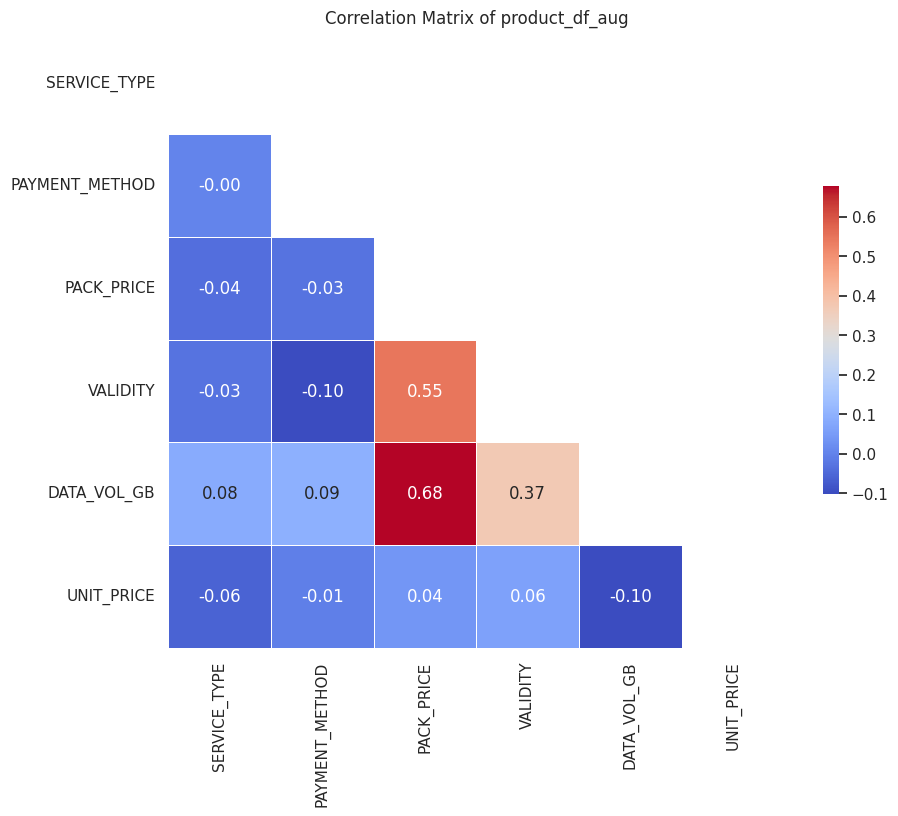

In [177]:
correlation_matrix = product_df_aug.drop(['HITS_MEAN', 'PACK_ID', 'PRODUCT_STATUS'], axis=1).corr()
sns.set(style="white")

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix of product_df_aug')
plt.show()

As expected, there is some correlation between the package price and data volume. This is a no-brainer since more data would require a customer to pay more. The more interesting insight is that there is a weak correlation between price and validity, which implies that services impose higher costs on longer package durations to incentivise buying packages that last shorter. This might also yield in higher purchase frequencies as an aftereffect.

# Modelling

For our predictions, we will use the tree-based method XGBoost since most of the features are categorical in nature. The numeric features will be scaled to have a mean of 0 and standard deviation of 1.

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [173]:
label_encoders = {}
categorical_columns = ['SERVICE_TYPE', 'PAYMENT_METHOD', 'VALIDITY']

for column in categorical_columns:
    le = LabelEncoder()
    product_df_aug[column] = le.fit_transform(product_df_aug[column])
    label_encoders[column] = le

continuous_features = ['UNIT_PRICE', 'PACK_PRICE', 'DATA_VOL_GB']
scaler = StandardScaler()
product_df_aug[continuous_features] = scaler.fit_transform(product_df_aug[continuous_features])

X = product_df_aug.drop(['HITS_MEAN', 'PACK_ID', 'PRODUCT_STATUS'], axis=1)
y = product_df_aug['HITS_MEAN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [174]:
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, seed=42)

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test data: {rmse}")

RMSE on test data: 1015.0838461108377


In [175]:
test_product_df[categorical_columns] = test_product_df[categorical_columns].apply(lambda col: label_encoders[col.name].transform(col))
test_product_df[continuous_features] = scaler.transform(test_product_df[continuous_features])

X_new_test = test_product_df.drop(['PACK_ID', 'PRODUCT_STATUS'], axis=1)

test_product_df['Predicted_HITS_MEAN_XGB'] = xgb_regressor.predict(X_new_test)
test_product_df['HITS_XGB'] = test_product_df['Predicted_HITS_MEAN_XGB'].round().astype(int)

final_xgb_df = test_product_df[['PACK_ID', 'HITS_XGB']]
final_xgb_df.rename(columns={'HITS_XGB': 'HITS'}, inplace=True)

/tmp/ipykernel_41571/362855470.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_xgb_df.rename(columns={'HITS_XGB': 'HITS'}, inplace=True)


In [176]:
final_xgb_df.to_csv('predicted_hits_xgb.csv', index=False)
final_xgb_df.head()

,PACK_ID,HITS
0,352,1016
1,1735,766
2,179,312
3,1434,2356
4,426,936


For ablation, we will also train an ensemble of random forest, gradient boosting trees and ridge regression.

In [178]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_regressor.fit(X_train, y_train)

ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X_train, y_train)

Ridge()

In [179]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_regressor.predict(X_test)))

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_regressor.predict(X_test)))

gb_rmse = np.sqrt(mean_squared_error(y_test, gb_regressor.predict(X_test)))

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_regressor.predict(X_test)))

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Gradient Boosting RMSE: {gb_rmse}")
print(f"Ridge Regression RMSE: {ridge_rmse}")

XGBoost RMSE: 1015.0838461108377
Random Forest RMSE: 1065.1186909928317
Gradient Boosting RMSE: 1055.9158520013177
Ridge Regression RMSE: 1112.0900228114247


In [100]:
predictions_xgb = xgb_regressor.predict(X_test)
predictions_rf = rf_regressor.predict(X_test)
predictions_gb = gb_regressor.predict(X_test)
predictions_ridge = ridge_regressor.predict(X_test)

average_predictions = (predictions_xgb + predictions_rf + predictions_gb + predictions_ridge) / 4

ensemble_rmse = np.sqrt(mean_squared_error(y_test, average_predictions))
print(f"Ensemble RMSE: {ensemble_rmse}")

Ensemble RMSE: 1043.5296385910808


Since the validation RMSE is worse than the XGBoost-based solution, this might indicate overengineering or the predictions between different models showing high variance. For our final result, we will proceed with the single XGBoost-based solution.

In [180]:
test_predictions_xgb = xgb_regressor.predict(X_new_test)
test_predictions_rf = rf_regressor.predict(X_new_test)
test_predictions_gb = gb_regressor.predict(X_new_test)
test_predictions_ridge = ridge_regressor.predict(X_new_test)

test_product_df['Predicted_HITS_MEAN_Ensemble'] = (test_predictions_xgb + test_predictions_rf + test_predictions_gb + test_predictions_ridge) / 4
test_product_df['HITS_Ensemble'] = test_product_df['Predicted_HITS_MEAN_Ensemble'].round().astype(int)

final_ensemble_df = test_product_df[['PACK_ID', 'HITS_Ensemble']]
final_ensemble_df.rename(columns={'HITS_Ensemble': 'HITS'}, inplace=True)

final_ensemble_df.to_csv('predicted_hits_ensemble.csv', index=False)
final_ensemble_df.head()

/tmp/ipykernel_41571/3714935934.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_ensemble_df.rename(columns={'HITS_Ensemble': 'HITS'}, inplace=True)


,PACK_ID,HITS
0,352,641
1,1735,458
2,179,398
3,1434,1550
4,426,758
